## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['25 hPa'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['25 hPa'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['25 hPa'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['25 hPa'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['25 hPa'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['25 hPa'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['25 hPa'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['25 hPa'] - data_df['25 hPa'].shift(lag)) / data_df['25 hPa'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['25 hPa'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['25 hPa'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['25 hPa'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['25 hPa'] - data_df['25 hPa'].mean()) / data_df['25 hPa'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['25 hPa'].median()
    mad = np.median(np.abs(data_df['25 hPa'] - median))
    data_df['mad_z_score'] = (data_df['25 hPa'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['25 hPa'] / data_df['25 hPa'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-01,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-01,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-01,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-01,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-01,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-01,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-01,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-11-01,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', '20 hPa', 'ema_3',
       'rolling_min_2', 'z_score', 'moving_average_3', 'mad_z_score',
       'moving_average_2', 'rolling_max_3', 'rolling_min_3',
       'interaction_ma_ema_2', 'lag_2', 'ema_12', 'interaction_ma_ema_3',
       'moving_median_2', 'lag_1', 'lag_3'],
      dtype='object')


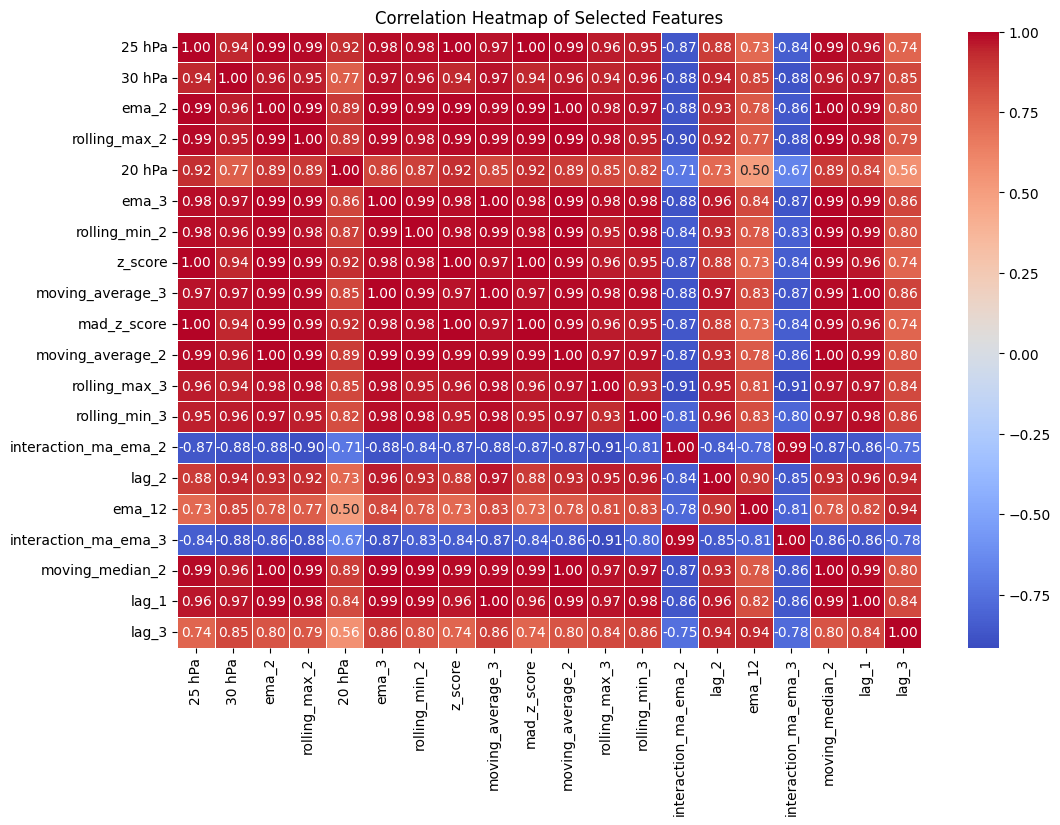

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(227, 28, 20) (227,)

Testing set shapes:
(98, 28, 20) (98,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - loss: 1.0320 - mae: 0.9419 - r_squared: -69.2743
Epoch 1: val_loss improved from inf to 0.65420, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - loss: 0.9557 - mae: 0.9091 - r_squared: -62.6200 - val_loss: 0.6542 - val_mae: 0.7411 - val_r_squared: -37.4970
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6808 - mae: 0.7617 - r_squared: -69.5669
Epoch 2: val_loss improved from 0.65420 to 0.46856, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.6645 - mae: 0.7480 - r_squared: -67.6977 - val_loss: 0.4686 - val_mae: 0.5984 - val_r_squared: -42.8388
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4781 - mae: 0.6195 - r_squared: -84.1797
Epoch 3: val_loss improved from 0.46856 to 0.31728, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.4715 - mae: 0.6032 - r_squared: -76.1611 - val_loss: 0.3173 - val_mae: 0.4629 - val_r_squared: -49.3831
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4024 - mae: 0.5141 - r_squared: -94.3059
Epoch 4: val_loss improved from 0.31728 to 0.25817, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3518 - mae: 0.4844 - r_squared: -86.3994 - val_loss: 0.2582 - val_mae: 0.4032 - val_r_squared: -58.9169
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2164 - mae: 0.3759 - r_squared: -111.6124
Epoch 5: val_loss did not improve from 0.25817
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2477 - mae: 0.3973 - r_squared: -101.6740 - val_loss: 0.2701 - val_mae: 0.3883 - val_r_squared: -65.5871
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2635 - mae: 0.3985 - r_squared: -120.4739
Epoch 6: val_loss improved from 0.25817 to 0.24830, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2369 - mae: 0.3695 - r_squared: -107.9194 - val_loss: 0.2483 - val_mae: 0.3581 - val_r_squared: -64.4111
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2501 - mae: 0.3721 - r_squared: -113.8440
Epoch 7: val_loss improved from 0.24830 to 0.16735, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2205 - mae: 0.3503 - r_squared: -103.0009 - val_loss: 0.1674 - val_mae: 0.2982 - val_r_squared: -62.1262
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1295 - mae: 0.2715 - r_squared: -108.4035
Epoch 8: val_loss improved from 0.16735 to 0.14273, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1495 - mae: 0.2856 - r_squared: -100.6504 - val_loss: 0.1427 - val_mae: 0.2550 - val_r_squared: -64.1921
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1316 - mae: 0.2390 - r_squared: -114.3538
Epoch 9: val_loss improved from 0.14273 to 0.11099, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1433 - mae: 0.2594 - r_squared: -104.4169 - val_loss: 0.1110 - val_mae: 0.2288 - val_r_squared: -64.5911
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1048 - mae: 0.2244 - r_squared: -116.8312
Epoch 10: val_loss improved from 0.11099 to 0.10191, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1374 - mae: 0.2522 - r_squared: -105.3797 - val_loss: 0.1019 - val_mae: 0.2233 - val_r_squared: -64.4240
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1393 - mae: 0.2365 - r_squared: -117.3614
Epoch 11: val_loss did not improve from 0.10191
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1346 - mae: 0.2452 - r_squared: -105.1270 - val_loss: 0.1330 - val_mae: 0.2581 - val_r_squared: -66.6399
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1002 - mae: 0.2213 - r_squared: -117.8608
Epoch 12: val_loss did not improve from 0.10191
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1250 - mae: 0.2456 - r_squared: -107.7100 - val_loss: 0.1228 - val_mae: 0.2459 - val_r_squared: -66.6280
Epoch 13/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1342 - mae: 0.2477 - r_squared: -119.0681
Epoch 13: val_loss improved from 0.10191 to 0.09939, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1200 - mae: 0.2420 - r_squared: -108.2040 - val_loss: 0.0994 - val_mae: 0.2184 - val_r_squared: -66.8281
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0931 - mae: 0.2111 - r_squared: -118.8732
Epoch 14: val_loss did not improve from 0.09939
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1090 - mae: 0.2291 - r_squared: -110.0676 - val_loss: 0.1015 - val_mae: 0.2127 - val_r_squared: -66.6523
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1120 - mae: 0.2122 - r_squared: -120.7913
Epoch 15: val_loss did not improve from 0.09939
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1044 - mae: 0.2162 - r_squared: -109.9125 - val_loss: 0.1057 - val_mae: 0.2184 - val_r_squared: -64.8130
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1294 - mae: 0.2446 - r_squared: -118.0396
Epoch 16: val_loss did not improve from 0.09939
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1118 - mae: 0.2296 - r_squared: -106.285

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0901 - mae: 0.2044 - r_squared: -108.7070 - val_loss: 0.0976 - val_mae: 0.2084 - val_r_squared: -68.8859
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0807 - mae: 0.1823 - r_squared: -127.1573
Epoch 19: val_loss improved from 0.09764 to 0.09242, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0922 - mae: 0.1980 - r_squared: -114.4093 - val_loss: 0.0924 - val_mae: 0.2039 - val_r_squared: -68.4350
Epoch 20/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0783 - mae: 0.1799 - r_squared: -125.5065
Epoch 20: val_loss improved from 0.09242 to 0.08563, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0846 - mae: 0.1942 - r_squared: -112.3842 - val_loss: 0.0856 - val_mae: 0.2054 - val_r_squared: -65.5981
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0650 - mae: 0.1740 - r_squared: -120.5813
Epoch 21: val_loss did not improve from 0.08563
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0773 - mae: 0.1916 - r_squared: -108.7070 - val_loss: 0.0917 - val_mae: 0.2176 - val_r_squared: -65.0868
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0942 - mae: 0.2027 - r_squared: -123.6953
Epoch 22: val_loss did not improve from 0.08563
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0896 - mae: 0.2022 - r_squared: -109.7504 - val_loss: 0.0898 - val_mae: 0.2124 - val_r_squared: -66.7761
Epoch 23/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0418 - mae: 0.1514 - r_squared: -125.6951
Epoch 23: val_loss improved from 0.08563 to 0.08501, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0730 - mae: 0.1852 - r_squared: -113.5551 - val_loss: 0.0850 - val_mae: 0.1995 - val_r_squared: -68.8412
Epoch 24/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0553 - mae: 0.1753 - r_squared: -124.8151
Epoch 24: val_loss did not improve from 0.08501
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0742 - mae: 0.1852 - r_squared: -114.4627 - val_loss: 0.0908 - val_mae: 0.2052 - val_r_squared: -67.2073
Epoch 25/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0930 - mae: 0.2007 - r_squared: -118.1055
Epoch 25: val_loss improved from 0.08501 to 0.08069, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0834 - mae: 0.1924 - r_squared: -109.4611 - val_loss: 0.0807 - val_mae: 0.2135 - val_r_squared: -64.1287
Epoch 26/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1104 - mae: 0.2447 - r_squared: -110.3077
Epoch 26: val_loss improved from 0.08069 to 0.07288, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0901 - mae: 0.2160 - r_squared: -104.9263 - val_loss: 0.0729 - val_mae: 0.1945 - val_r_squared: -66.1998
Epoch 27/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0854 - mae: 0.1916 - r_squared: -118.9571
Epoch 27: val_loss did not improve from 0.07288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0797 - mae: 0.1909 - r_squared: -109.9386 - val_loss: 0.0863 - val_mae: 0.1969 - val_r_squared: -69.3660
Epoch 28/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0832 - mae: 0.1864 - r_squared: -128.8127
Epoch 28: val_loss did not improve from 0.07288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0823 - mae: 0.1871 - r_squared: -114.4042 - val_loss: 0.0785 - val_mae: 0.1925 - val_r_squared: -67.2723
Epoch 29/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0527 - mae: 0.1592 - r_squared: -122.8467
Epoch 29: val_loss did not improve from 0.07288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0700 - mae: 0.1766 - r_squared: -111.3

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0735 - mae: 0.1741 - r_squared: -114.3515 - val_loss: 0.0718 - val_mae: 0.1859 - val_r_squared: -68.4295
Epoch 33/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1025 - mae: 0.2073 - r_squared: -123.2877
Epoch 33: val_loss did not improve from 0.07177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0835 - mae: 0.1887 - r_squared: -111.8799 - val_loss: 0.0742 - val_mae: 0.1925 - val_r_squared: -66.4575
Epoch 34/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0459 - mae: 0.1542 - r_squared: -121.3370
Epoch 34: val_loss improved from 0.07177 to 0.06656, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0647 - mae: 0.1697 - r_squared: -110.1027 - val_loss: 0.0666 - val_mae: 0.1726 - val_r_squared: -68.0223
Epoch 35/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0686 - mae: 0.1596 - r_squared: -127.0876
Epoch 35: val_loss did not improve from 0.06656
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0730 - mae: 0.1703 - r_squared: -113.4403 - val_loss: 0.0748 - val_mae: 0.1797 - val_r_squared: -67.7675
Epoch 36/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0560 - mae: 0.1551 - r_squared: -123.7249
Epoch 36: val_loss did not improve from 0.06656
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0659 - mae: 0.1657 - r_squared: -111.9222 - val_loss: 0.0776 - val_mae: 0.1901 - val_r_squared: -67.5406
Epoch 37/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0960 - mae: 0.1907 - r_squared: -121.3110
Epoch 37: val_loss did not improve from 0.06656
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0792 - mae: 0.1847 - r_squared: -111.222

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0518 - mae: 0.1622 - r_squared: -108.9756 - val_loss: 0.0602 - val_mae: 0.1657 - val_r_squared: -66.4973
Epoch 57/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0497 - mae: 0.1624 - r_squared: -117.0506
Epoch 57: val_loss did not improve from 0.06022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0549 - mae: 0.1650 - r_squared: -108.6686 - val_loss: 0.0782 - val_mae: 0.1833 - val_r_squared: -69.3873
Epoch 58/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0362 - mae: 0.1460 - r_squared: -123.6491
Epoch 58: val_loss did not improve from 0.06022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0488 - mae: 0.1540 - r_squared: -113.7574 - val_loss: 0.0638 - val_mae: 0.1640 - val_r_squared: -69.5559
Epoch 59/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0390 - mae: 0.1359 - r_squared: -123.3414
Epoch 59: val_loss did not improve from 0.06022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0477 - mae: 0.1491 - r_squared: -113.1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0539 - mae: 0.1642 - r_squared: -105.5910 - val_loss: 0.0591 - val_mae: 0.1574 - val_r_squared: -67.5091
Epoch 70/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0501 - mae: 0.1591 - r_squared: -120.2633
Epoch 70: val_loss did not improve from 0.05911
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0493 - mae: 0.1569 - r_squared: -111.3804 - val_loss: 0.0843 - val_mae: 0.1780 - val_r_squared: -71.0511
Epoch 71/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0355 - mae: 0.1356 - r_squared: -128.7954
Epoch 71: val_loss did not improve from 0.05911
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0456 - mae: 0.1475 - r_squared: -116.3529 - val_loss: 0.0833 - val_mae: 0.1856 - val_r_squared: -69.5233
Epoch 72/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0616 - mae: 0.1770 - r_squared: -125.6095
Epoch 72: val_loss did not improve from 0.05911
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0545 - mae: 0.1654 - r_squared: -111.84

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0304 - mae: 0.1214 - r_squared: -115.2287 - val_loss: 0.0568 - val_mae: 0.1578 - val_r_squared: -69.4084
Epoch 122/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0304 - mae: 0.1302 - r_squared: -121.9430
Epoch 122: val_loss did not improve from 0.05676
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0323 - mae: 0.1289 - r_squared: -113.0799 - val_loss: 0.0698 - val_mae: 0.1689 - val_r_squared: -69.1913
Epoch 123/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0384 - mae: 0.1306 - r_squared: -124.0029
Epoch 123: val_loss did not improve from 0.05676
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0323 - mae: 0.1223 - r_squared: -112.3768 - val_loss: 0.0637 - val_mae: 0.1700 - val_r_squared: -69.2892
Epoch 124/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0321 - mae: 0.1161 - r_squared: -122.6852
Epoch 124: val_loss did not improve from 0.05676
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0306 - mae: 0.1184 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0223 - mae: 0.0951 - r_squared: -113.5082 - val_loss: 0.0560 - val_mae: 0.1652 - val_r_squared: -70.3144
Epoch 150/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0227 - mae: 0.1037 - r_squared: -128.3338
Epoch 150: val_loss did not improve from 0.05603
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0248 - mae: 0.1072 - r_squared: -115.6646 - val_loss: 0.0721 - val_mae: 0.1786 - val_r_squared: -70.8702
Epoch 151/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0147 - mae: 0.0885 - r_squared: -126.8032
Epoch 151: val_loss did not improve from 0.05603
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0224 - mae: 0.1033 - r_squared: -115.4502 - val_loss: 0.0663 - val_mae: 0.1734 - val_r_squared: -69.6983
Epoch 152/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0290 - mae: 0.1117 - r_squared: -123.1833
Epoch 152: val_loss did not improve from 0.05603
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0265 - mae: 0.1098 - r_squared: -

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9990 - mae: 0.8758 - r_squared: -70.5618
Epoch 1: val_loss improved from inf to 0.52283, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.9910 - mae: 0.8694 - r_squared: -68.4401 - val_loss: 0.5228 - val_mae: 0.6319 - val_r_squared: -43.2857
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7221 - mae: 0.7000 - r_squared: -81.8316
Epoch 2: val_loss improved from 0.52283 to 0.45969, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - loss: 0.7114 - mae: 0.6934 - r_squared: -79.2134 - val_loss: 0.4597 - val_mae: 0.5470 - val_r_squared: -51.1065
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5053 - mae: 0.5575 - r_squared: -90.2650
Epoch 3: val_loss improved from 0.45969 to 0.44291, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - loss: 0.5047 - mae: 0.5558 - r_squared: -87.6583 - val_loss: 0.4429 - val_mae: 0.4815 - val_r_squared: -61.0157
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.5274 - mae: 0.5530 - r_squared: -103.9900
Epoch 4: val_loss improved from 0.44291 to 0.38080, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 0.5274 - mae: 0.5525 - r_squared: -100.7780 - val_loss: 0.3808 - val_mae: 0.4392 - val_r_squared: -60.1724
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4702 - mae: 0.5137 - r_squared: -103.1660
Epoch 5: val_loss improved from 0.38080 to 0.32909, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - loss: 0.4763 - mae: 0.5170 - r_squared: -99.4426 - val_loss: 0.3291 - val_mae: 0.4435 - val_r_squared: -52.8413
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4042 - mae: 0.4820 - r_squared: -96.8660 
Epoch 6: val_loss improved from 0.32909 to 0.31048, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - loss: 0.4102 - mae: 0.4847 - r_squared: -93.7380 - val_loss: 0.3105 - val_mae: 0.4576 - val_r_squared: -49.4720
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3535 - mae: 0.4953 - r_squared: -90.0487
Epoch 7: val_loss improved from 0.31048 to 0.28814, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - loss: 0.3483 - mae: 0.4894 - r_squared: -87.7056 - val_loss: 0.2881 - val_mae: 0.4428 - val_r_squared: -49.3710
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3239 - mae: 0.4559 - r_squared: -95.5240 
Epoch 8: val_loss improved from 0.28814 to 0.25971, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - loss: 0.3266 - mae: 0.4559 - r_squared: -92.4028 - val_loss: 0.2597 - val_mae: 0.4077 - val_r_squared: -51.3805
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3118 - mae: 0.4421 - r_squared: -95.0147 
Epoch 9: val_loss improved from 0.25971 to 0.23266, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - loss: 0.3128 - mae: 0.4434 - r_squared: -92.3023 - val_loss: 0.2327 - val_mae: 0.3679 - val_r_squared: -55.0199
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2310 - mae: 0.3738 - r_squared: -101.8309
Epoch 10: val_loss improved from 0.23266 to 0.21969, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - loss: 0.2368 - mae: 0.3786 - r_squared: -98.3963 - val_loss: 0.2197 - val_mae: 0.3464 - val_r_squared: -59.2985
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2557 - mae: 0.3757 - r_squared: -111.1872
Epoch 11: val_loss improved from 0.21969 to 0.20755, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - loss: 0.2590 - mae: 0.3791 - r_squared: -107.3865 - val_loss: 0.2076 - val_mae: 0.3352 - val_r_squared: -60.5285
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2252 - mae: 0.3740 - r_squared: -112.8298
Epoch 12: val_loss improved from 0.20755 to 0.19261, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - loss: 0.2291 - mae: 0.3760 - r_squared: -108.8176 - val_loss: 0.1926 - val_mae: 0.3207 - val_r_squared: -59.0183
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2476 - mae: 0.3876 - r_squared: -106.9125
Epoch 13: val_loss improved from 0.19261 to 0.18385, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.2425 - mae: 0.3858 - r_squared: -104.0548 - val_loss: 0.1838 - val_mae: 0.3149 - val_r_squared: -57.5401
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2275 - mae: 0.3640 - r_squared: -105.5924
Epoch 14: val_loss improved from 0.18385 to 0.18171, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.2255 - mae: 0.3628 - r_squared: -102.3341 - val_loss: 0.1817 - val_mae: 0.3220 - val_r_squared: -56.7561
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2062 - mae: 0.3447 - r_squared: -108.6635
Epoch 15: val_loss improved from 0.18171 to 0.17007, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 0.2016 - mae: 0.3411 - r_squared: -105.4133 - val_loss: 0.1701 - val_mae: 0.3084 - val_r_squared: -57.5997
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1805 - mae: 0.3315 - r_squared: -107.6575
Epoch 16: val_loss improved from 0.17007 to 0.15974, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - loss: 0.1824 - mae: 0.3319 - r_squared: -104.6526 - val_loss: 0.1597 - val_mae: 0.2926 - val_r_squared: -58.8812
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2080 - mae: 0.3451 - r_squared: -106.7230
Epoch 17: val_loss improved from 0.15974 to 0.15591, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - loss: 0.2093 - mae: 0.3473 - r_squared: -103.3690 - val_loss: 0.1559 - val_mae: 0.2877 - val_r_squared: -59.3935
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1803 - mae: 0.3387 - r_squared: -112.9792
Epoch 18: val_loss improved from 0.15591 to 0.15545, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - loss: 0.1823 - mae: 0.3400 - r_squared: -108.9762 - val_loss: 0.1555 - val_mae: 0.2929 - val_r_squared: -58.4441
Epoch 19/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2149 - mae: 0.3513 - r_squared: -107.3774 
Epoch 19: val_loss improved from 0.15545 to 0.14854, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - loss: 0.2128 - mae: 0.3515 - r_squared: -104.0896 - val_loss: 0.1485 - val_mae: 0.2894 - val_r_squared: -59.4609
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1631 - mae: 0.3151 - r_squared: -110.9427
Epoch 20: val_loss improved from 0.14854 to 0.14499, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 0.1651 - mae: 0.3166 - r_squared: -106.9515 - val_loss: 0.1450 - val_mae: 0.2840 - val_r_squared: -62.1653
Epoch 21/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1601 - mae: 0.3156 - r_squared: -112.5329
Epoch 21: val_loss improved from 0.14499 to 0.14072, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - loss: 0.1636 - mae: 0.3202 - r_squared: -109.8174 - val_loss: 0.1407 - val_mae: 0.2778 - val_r_squared: -64.7753
Epoch 22/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1547 - mae: 0.3027 - r_squared: -116.5916
Epoch 22: val_loss improved from 0.14072 to 0.13849, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.1548 - mae: 0.3029 - r_squared: -112.3366 - val_loss: 0.1385 - val_mae: 0.2744 - val_r_squared: -60.9611
Epoch 23/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1537 - mae: 0.3006 - r_squared: -108.5648
Epoch 23: val_loss improved from 0.13849 to 0.13477, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - loss: 0.1540 - mae: 0.3003 - r_squared: -104.8392 - val_loss: 0.1348 - val_mae: 0.2825 - val_r_squared: -59.1827
Epoch 24/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1536 - mae: 0.3019 - r_squared: -106.3731
Epoch 24: val_loss improved from 0.13477 to 0.13119, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 0.1544 - mae: 0.3031 - r_squared: -103.0408 - val_loss: 0.1312 - val_mae: 0.2767 - val_r_squared: -61.6679
Epoch 25/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1359 - mae: 0.2909 - r_squared: -108.9206
Epoch 25: val_loss did not improve from 0.13119
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1357 - mae: 0.2909 - r_squared: -106.1538 - val_loss: 0.1398 - val_mae: 0.2728 - val_r_squared: -67.9038
Epoch 26/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1356 - mae: 0.2726 - r_squared: -117.9445
Epoch 26: val_loss did not improve from 0.13119
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1373 - mae: 0.2745 - r_squared: -114.8567 - val_loss: 0.1326 - val_mae: 0.2689 - val_r_squared: -66.6390
Epoch 27/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1482 - mae: 0.2957 - r_squared: -117.8418 
Epoch 27: val_loss improved from 0.13119 to 0.12863, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.1491 - mae: 0.2968 - r_squared: -113.9522 - val_loss: 0.1286 - val_mae: 0.2727 - val_r_squared: -59.8725
Epoch 28/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1511 - mae: 0.3013 - r_squared: -106.0590 
Epoch 28: val_loss improved from 0.12863 to 0.12202, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - loss: 0.1489 - mae: 0.2972 - r_squared: -102.7755 - val_loss: 0.1220 - val_mae: 0.2684 - val_r_squared: -59.0387
Epoch 29/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1152 - mae: 0.2671 - r_squared: -108.0465
Epoch 29: val_loss improved from 0.12202 to 0.10706, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - loss: 0.1163 - mae: 0.2682 - r_squared: -104.8890 - val_loss: 0.1071 - val_mae: 0.2410 - val_r_squared: -64.0400
Epoch 30/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1435 - mae: 0.2928 - r_squared: -114.7544
Epoch 30: val_loss did not improve from 0.10706
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1427 - mae: 0.2912 - r_squared: -111.8177 - val_loss: 0.1165 - val_mae: 0.2468 - val_r_squared: -66.3721
Epoch 31/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1208 - mae: 0.2699 - r_squared: -119.2614
Epoch 31: val_loss did not improve from 0.10706
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1247 - mae: 0.2738 - r_squared: -115.4176 - val_loss: 0.1071 - val_mae: 0.2384 - val_r_squared: -61.8358
Epoch 32/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1001 - mae: 0.2491 - r_squared: -111.8282
Epoch 32: val_loss improved from 0.10706 to 0.10485, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - loss: 0.1016 - mae: 0.2504 - r_squared: -108.1667 - val_loss: 0.1049 - val_mae: 0.2495 - val_r_squared: -57.6731
Epoch 33/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1110 - mae: 0.2494 - r_squared: -106.6714 
Epoch 33: val_loss improved from 0.10485 to 0.09780, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - loss: 0.1127 - mae: 0.2524 - r_squared: -103.0258 - val_loss: 0.0978 - val_mae: 0.2366 - val_r_squared: -59.3419
Epoch 34/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1181 - mae: 0.2753 - r_squared: -106.5752
Epoch 34: val_loss improved from 0.09780 to 0.09504, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.1179 - mae: 0.2752 - r_squared: -103.3233 - val_loss: 0.0950 - val_mae: 0.2356 - val_r_squared: -67.1452
Epoch 35/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1105 - mae: 0.2610 - r_squared: -120.6646
Epoch 35: val_loss did not improve from 0.09504
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.1110 - mae: 0.2617 - r_squared: -117.3602 - val_loss: 0.1099 - val_mae: 0.2495 - val_r_squared: -70.6449
Epoch 36/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1155 - mae: 0.2680 - r_squared: -123.1541 
Epoch 36: val_loss improved from 0.09504 to 0.09271, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - loss: 0.1167 - mae: 0.2690 - r_squared: -118.9716 - val_loss: 0.0927 - val_mae: 0.2256 - val_r_squared: -64.7016
Epoch 37/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1114 - mae: 0.2486 - r_squared: -111.3680 
Epoch 37: val_loss improved from 0.09271 to 0.09107, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step - loss: 0.1094 - mae: 0.2475 - r_squared: -107.4772 - val_loss: 0.0911 - val_mae: 0.2296 - val_r_squared: -62.4287
Epoch 38/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1146 - mae: 0.2653 - r_squared: -110.7810
Epoch 38: val_loss improved from 0.09107 to 0.08987, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - loss: 0.1152 - mae: 0.2650 - r_squared: -107.6534 - val_loss: 0.0899 - val_mae: 0.2225 - val_r_squared: -64.5261
Epoch 39/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1196 - mae: 0.2604 - r_squared: -115.6217
Epoch 39: val_loss did not improve from 0.08987
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.1186 - mae: 0.2585 - r_squared: -111.9972 - val_loss: 0.0947 - val_mae: 0.2250 - val_r_squared: -66.1370
Epoch 40/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0999 - mae: 0.2519 - r_squared: -116.5746 
Epoch 40: val_loss did not improve from 0.08987
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.1024 - mae: 0.2530 - r_squared: -112.9581 - val_loss: 0.0901 - val_mae: 0.2148 - val_r_squared: -66.3904
Epoch 41/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1001 - mae: 0.2293 - r_squared: -114.5248
Epoch 41: val_loss improved from 0.08987 to 0.08317, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - loss: 0.0985 - mae: 0.2290 - r_squared: -110.9258 - val_loss: 0.0832 - val_mae: 0.2082 - val_r_squared: -64.8017
Epoch 42/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0874 - mae: 0.2146 - r_squared: -114.5366
Epoch 42: val_loss improved from 0.08317 to 0.08212, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - loss: 0.0901 - mae: 0.2194 - r_squared: -110.7195 - val_loss: 0.0821 - val_mae: 0.2076 - val_r_squared: -64.1062
Epoch 43/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0922 - mae: 0.2463 - r_squared: -113.2837 
Epoch 43: val_loss improved from 0.08212 to 0.07664, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step - loss: 0.0932 - mae: 0.2475 - r_squared: -109.8287 - val_loss: 0.0766 - val_mae: 0.1985 - val_r_squared: -65.9043
Epoch 44/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0947 - mae: 0.2349 - r_squared: -114.4796
Epoch 44: val_loss improved from 0.07664 to 0.07520, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - loss: 0.0936 - mae: 0.2337 - r_squared: -111.0157 - val_loss: 0.0752 - val_mae: 0.1952 - val_r_squared: -66.9928
Epoch 45/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0858 - mae: 0.2228 - r_squared: -115.8809
Epoch 45: val_loss improved from 0.07520 to 0.07268, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - loss: 0.0867 - mae: 0.2235 - r_squared: -112.1763 - val_loss: 0.0727 - val_mae: 0.1928 - val_r_squared: -65.7728
Epoch 46/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0810 - mae: 0.2137 - r_squared: -116.7519
Epoch 46: val_loss did not improve from 0.07268
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0831 - mae: 0.2175 - r_squared: -112.9623 - val_loss: 0.0772 - val_mae: 0.2042 - val_r_squared: -64.8852
Epoch 47/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1017 - mae: 0.2452 - r_squared: -113.4923
Epoch 47: val_loss did not improve from 0.07268
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1003 - mae: 0.2438 - r_squared: -109.8517 - val_loss: 0.0824 - val_mae: 0.2127 - val_r_squared: -64.4655
Epoch 48/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0862 - mae: 0.2207 - r_squared: -113.2459
Epoch 48: val_loss did not improve from 0.07268
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.0841 - mae: 0.2186 - r_squared: -10

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - loss: 0.0826 - mae: 0.2179 - r_squared: -109.8329 - val_loss: 0.0711 - val_mae: 0.1952 - val_r_squared: -64.9687
Epoch 56/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0842 - mae: 0.2185 - r_squared: -112.2847
Epoch 56: val_loss did not improve from 0.07110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0819 - mae: 0.2154 - r_squared: -109.0554 - val_loss: 0.0732 - val_mae: 0.1982 - val_r_squared: -66.4869
Epoch 57/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0997 - mae: 0.2405 - r_squared: -114.8391
Epoch 57: val_loss improved from 0.07110 to 0.07096, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.0974 - mae: 0.2377 - r_squared: -111.2150 - val_loss: 0.0710 - val_mae: 0.1923 - val_r_squared: -67.9937
Epoch 58/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0804 - mae: 0.2203 - r_squared: -114.4172
Epoch 58: val_loss did not improve from 0.07096
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0810 - mae: 0.2210 - r_squared: -111.0540 - val_loss: 0.0768 - val_mae: 0.2042 - val_r_squared: -70.6562
Epoch 59/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0704 - mae: 0.2099 - r_squared: -117.4975
Epoch 59: val_loss did not improve from 0.07096
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0719 - mae: 0.2111 - r_squared: -114.2990 - val_loss: 0.0718 - val_mae: 0.1968 - val_r_squared: -68.3638
Epoch 60/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0760 - mae: 0.2114 - r_squared: -112.6865
Epoch 60: val_loss did not improve from 0.07096
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0763 - mae: 0.2127 - r_squared: -10

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - loss: 0.0537 - mae: 0.1731 - r_squared: -112.3519 - val_loss: 0.0703 - val_mae: 0.1916 - val_r_squared: -66.5950
Epoch 81/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0709 - mae: 0.2123 - r_squared: -116.1366 
Epoch 81: val_loss did not improve from 0.07034
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0715 - mae: 0.2128 - r_squared: -112.1739 - val_loss: 0.0746 - val_mae: 0.2007 - val_r_squared: -64.7392
Epoch 82/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0832 - mae: 0.2259 - r_squared: -113.6546
Epoch 82: val_loss did not improve from 0.07034
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0825 - mae: 0.2254 - r_squared: -110.4002 - val_loss: 0.0731 - val_mae: 0.1978 - val_r_squared: -67.6124
Epoch 83/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0718 - mae: 0.2131 - r_squared: -118.6255
Epoch 83: val_loss did not improve from 0.07034
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0714 - mae: 0.2120 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - loss: 0.0577 - mae: 0.1873 - r_squared: -113.2865 - val_loss: 0.0689 - val_mae: 0.1818 - val_r_squared: -66.0740
Epoch 85/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0648 - mae: 0.1964 - r_squared: -113.6338
Epoch 85: val_loss improved from 0.06892 to 0.06820, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - loss: 0.0649 - mae: 0.1970 - r_squared: -109.8715 - val_loss: 0.0682 - val_mae: 0.1841 - val_r_squared: -66.7114
Epoch 86/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0642 - mae: 0.1924 - r_squared: -116.6741
Epoch 86: val_loss did not improve from 0.06820
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.0635 - mae: 0.1902 - r_squared: -113.1848 - val_loss: 0.0734 - val_mae: 0.1913 - val_r_squared: -66.9606
Epoch 87/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0654 - mae: 0.1907 - r_squared: -118.1398 
Epoch 87: val_loss did not improve from 0.06820
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.0649 - mae: 0.1896 - r_squared: -114.1031 - val_loss: 0.0729 - val_mae: 0.1907 - val_r_squared: -66.2687
Epoch 88/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0611 - mae: 0.1888 - r_squared: -113.3624 
Epoch 88: val_loss did not improve from 0.06820
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0607 - mae: 0.1874 - r_squared: -1

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


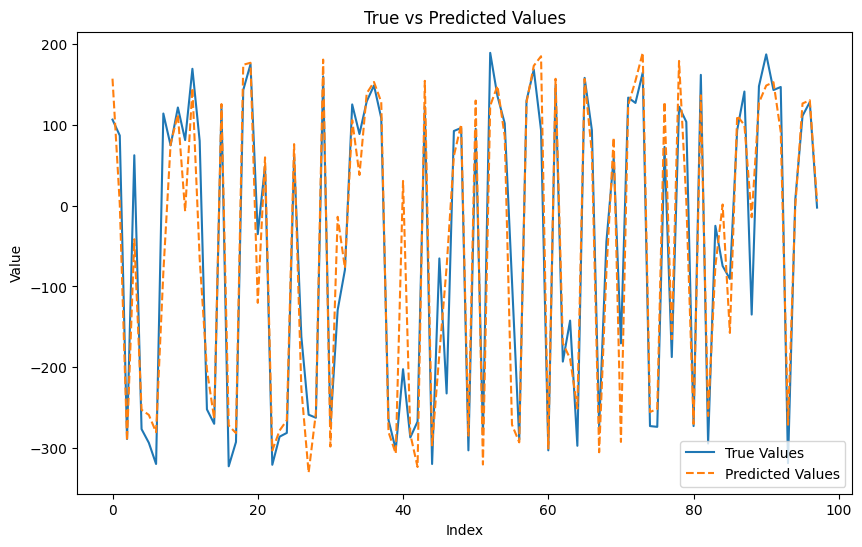

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


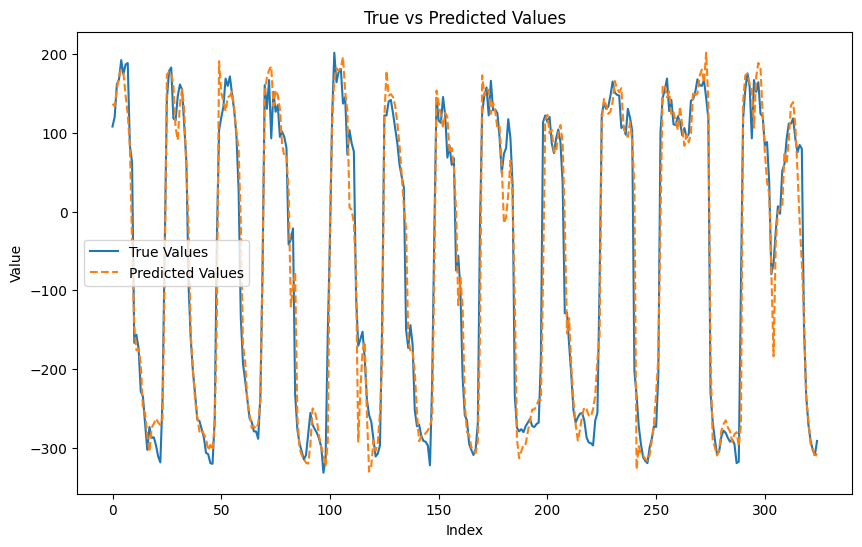

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


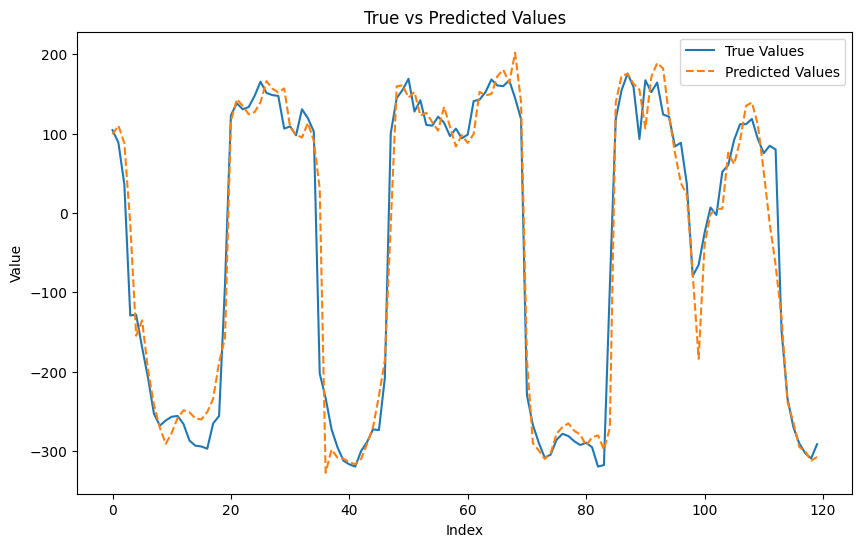

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step


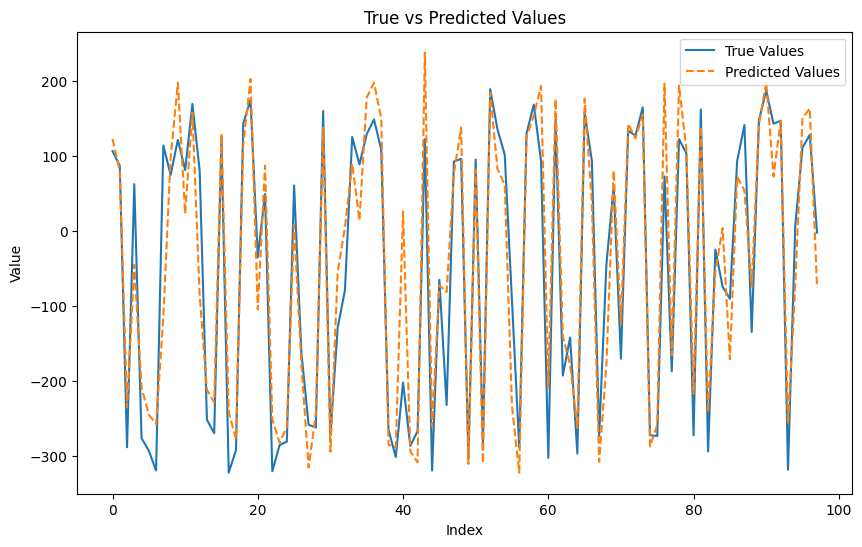

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


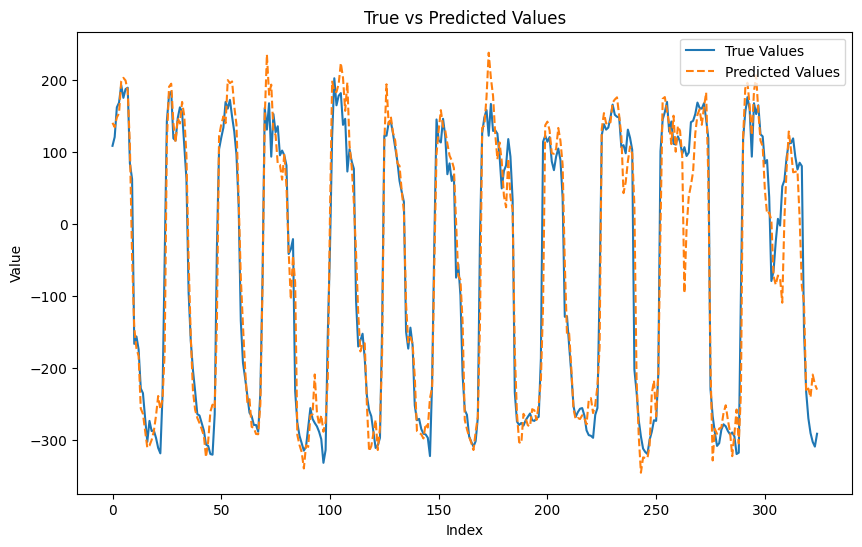

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


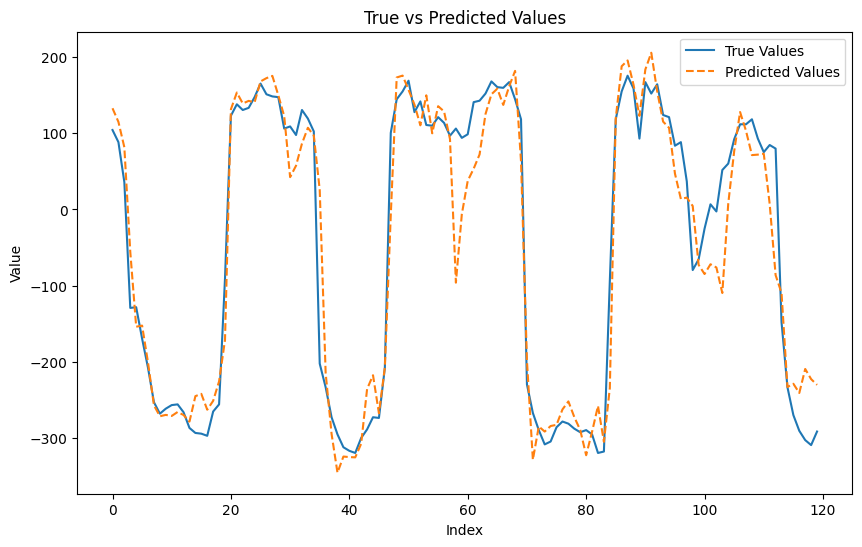

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


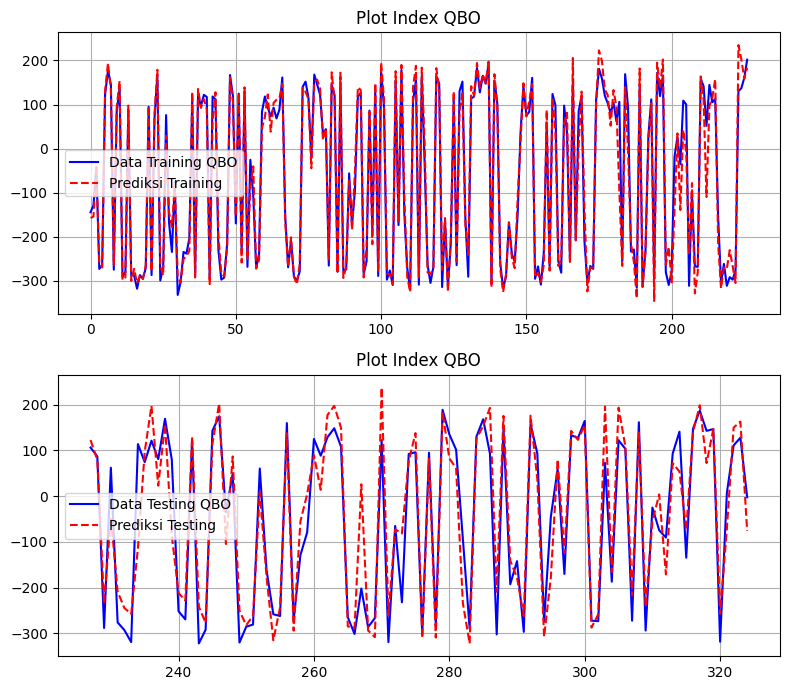

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.055018784109260276
RMSE:  0.2345608324278806
R-squared:  0.9450545842031648
MAE:  0.1516557415823264
Log Likelihood:  -202725.86549744726
MAPE:  174.46083299440375


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.06022829720549777
RMSE:  0.2454145415526508
R-squared:  0.9398520180649638
MAE:  0.16448287148698731
Log Likelihood:  -202635.09308668232
MAPE:  174.4093373889298


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.10318759316164457
RMSE:  0.3212282571033323
R-squared:  0.8916506890927729
MAE:  0.21638751962686836
Log Likelihood:  -17892.54481182598
MAPE:  216.8516792100582


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.12007986106522611
RMSE:  0.34652541186069763
R-squared:  0.8739134250386904
MAE:  0.25876433443045005
Log Likelihood:  -17745.492424477176
MAPE:  214.00444373483643


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  1957.9886043059687
RMSE:  44.249165012528415
R-squared:  0.9450545836508418
MAE:  28.609379366052526
Log Likelihood:  -318471.80322301143
MAPE:  29.565224299438736


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  2143.3828303142336
RMSE:  46.29668271392923
R-squared:  0.9398520186745432
MAE:  31.02917699415325
Log Likelihood:  -348598.36494935444
MAPE:  41.19476857020023


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  1953.9955009515663
RMSE:  44.20402132104687
R-squared:  0.9461488637857156
MAE:  26.639814392616437
Log Likelihood:  -117350.00268107856
MAPE:  25.708270560965456


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  2864.2221076938044
RMSE:  53.5184277393666
R-squared:  0.9210634749188162
MAE:  35.72789373480305
Log Likelihood:  -171963.5990856128
MAPE:  63.385240860110116


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  3672.2027888910943
RMSE:  60.59870286475689
R-squared:  0.8916506875042626
MAE:  40.82082695226369
Log Likelihood:  -180027.99263191767
MAPE:  40.95959928205837
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  1217.9312883065784
RMSE:  34.89887230709007
R-squared:  0.9664183596963438
MAE:  23.337475253830807
Log Likelihood:  -138443.80026983412
MAPE:  24.646027943896875


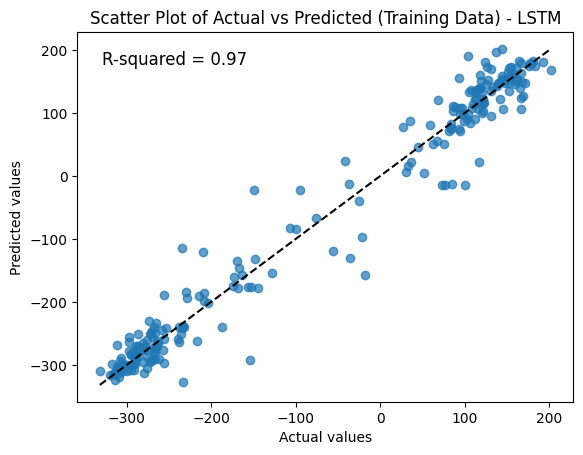

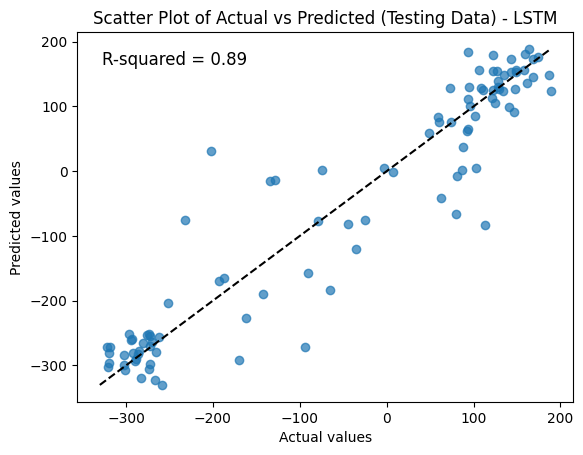

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  4273.358598112147
RMSE:  65.37093083406528
R-squared:  0.8739134266893204
MAE:  48.81507869882781
Log Likelihood:  -209484.62728374923
MAPE:  82.08566535062525
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  1223.8338196432192
RMSE:  34.98333631378258
R-squared:  0.9662556110370958
MAE:  23.350681884257696
Log Likelihood:  -139113.73757654283
MAPE:  23.541432556398497


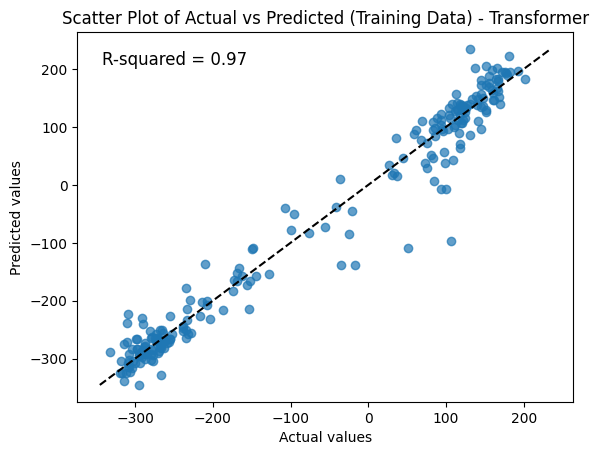

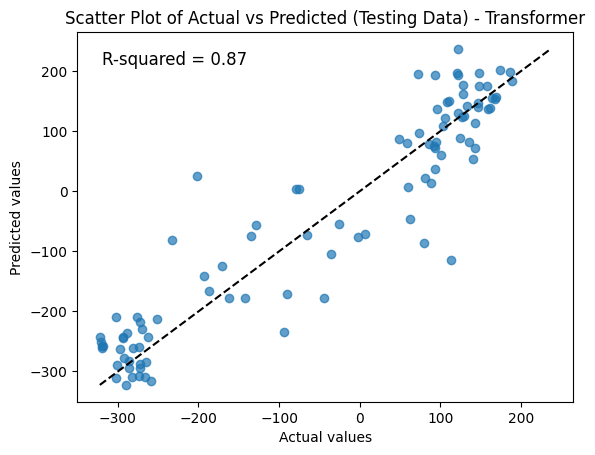

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

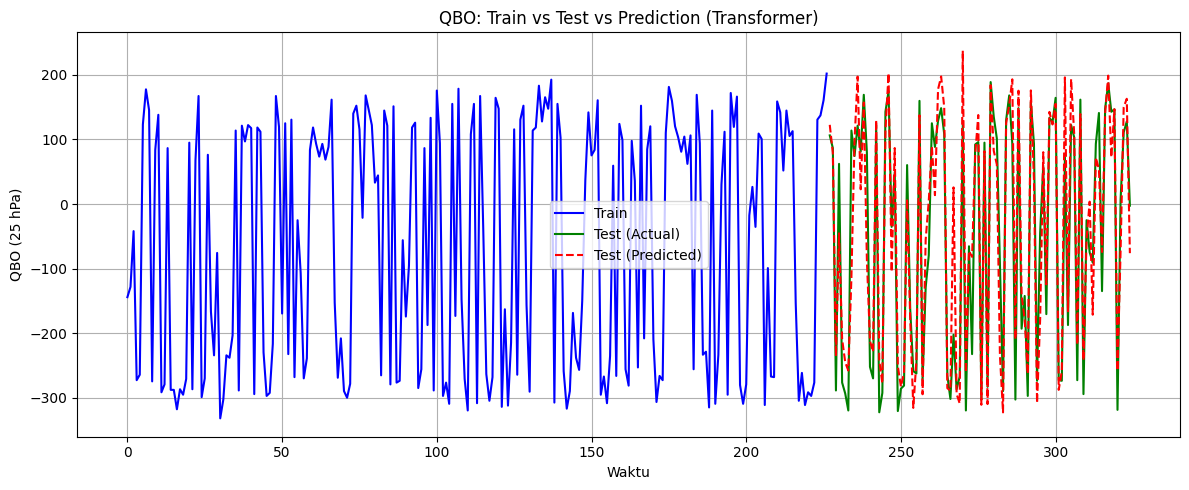

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

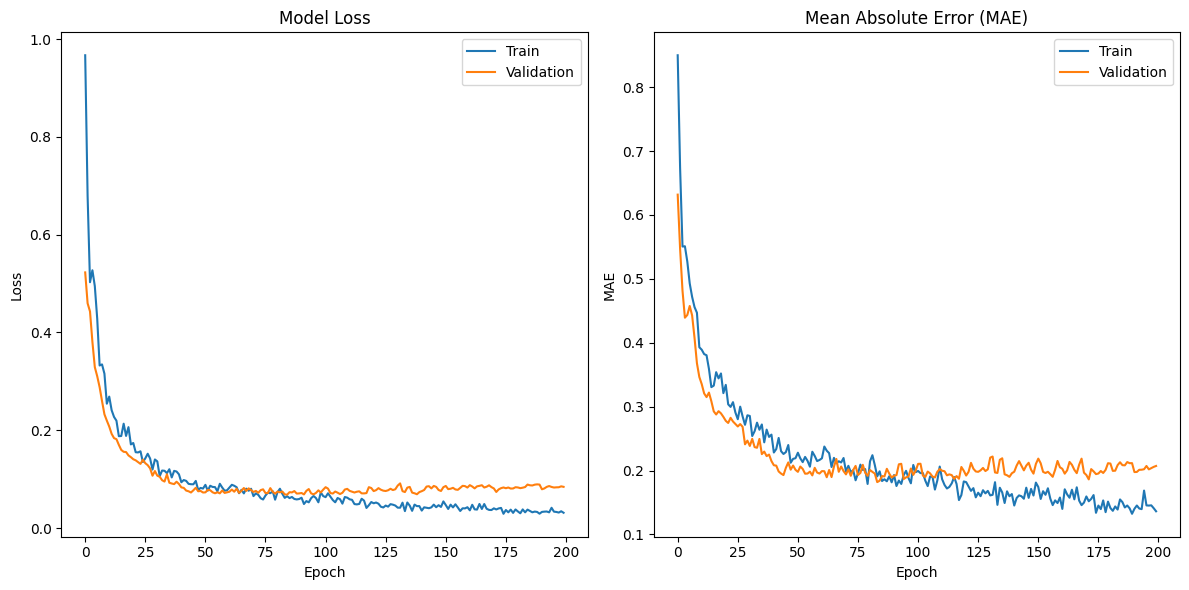

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

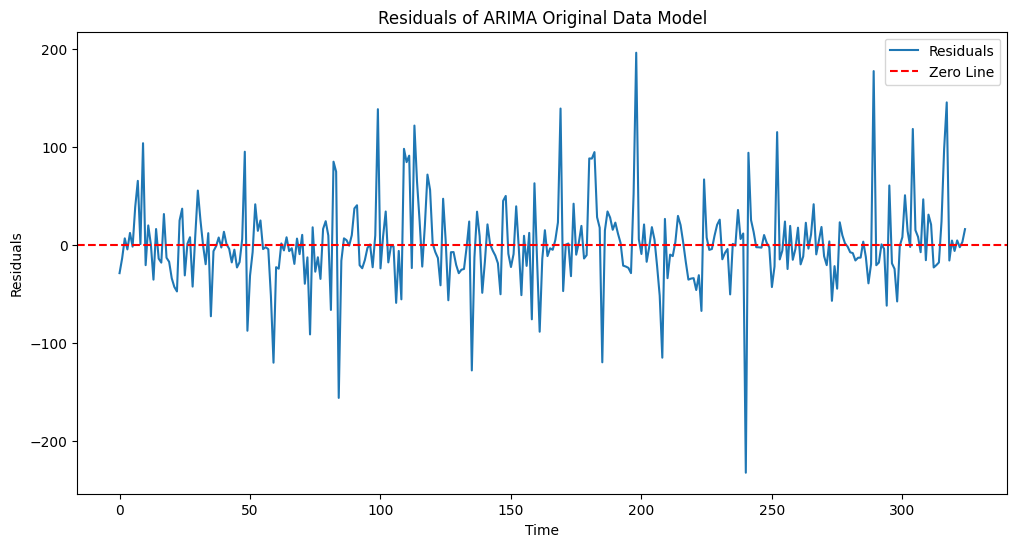

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

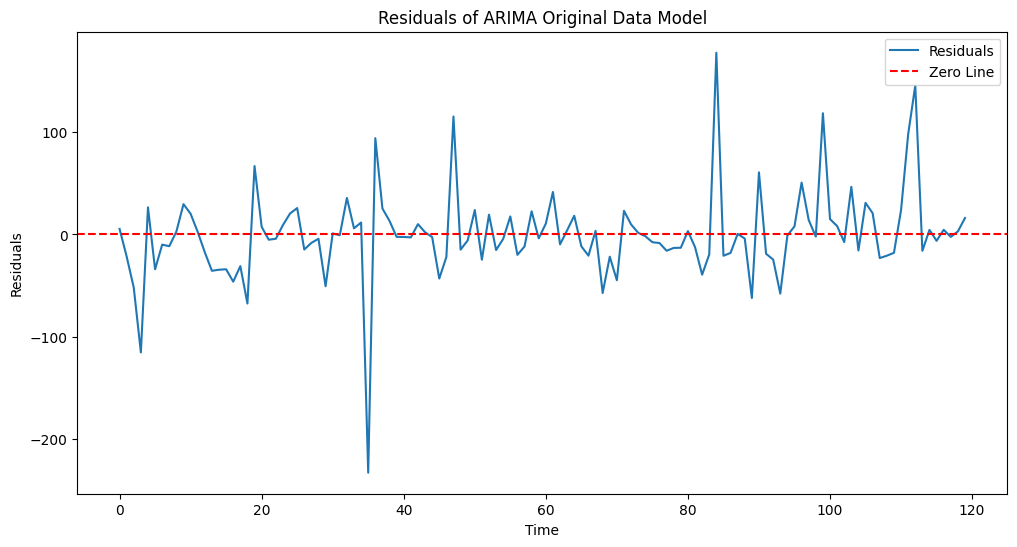

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

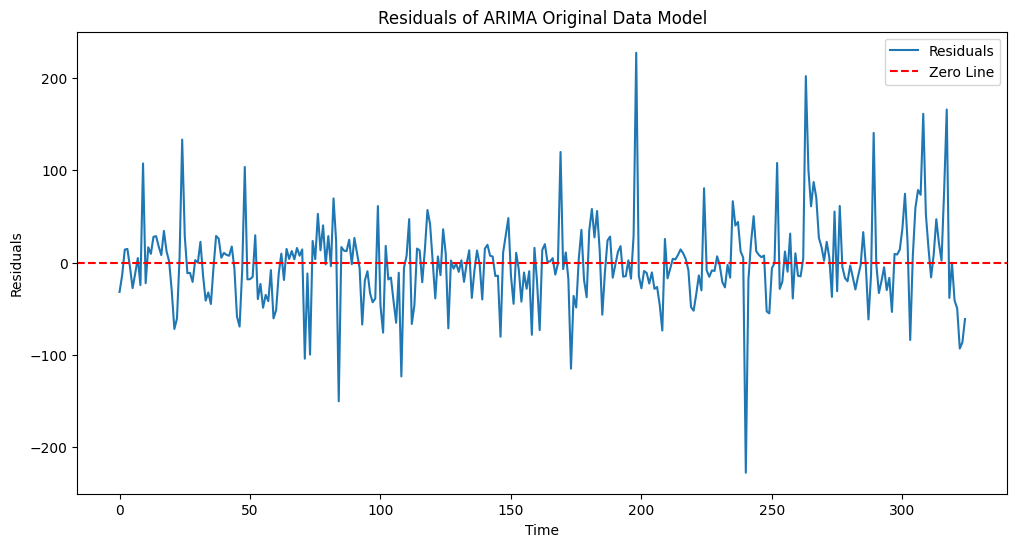

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

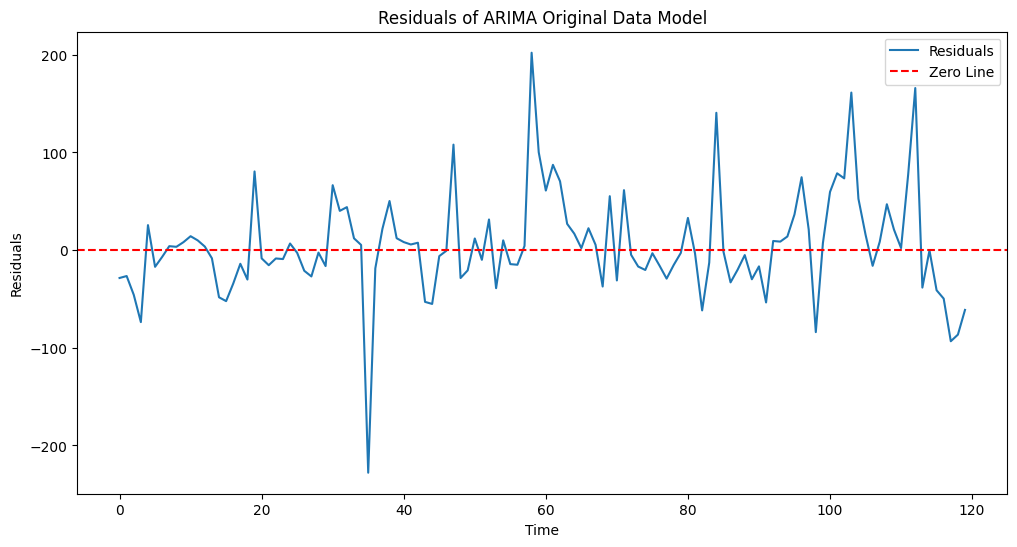

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.896563565047507
P-value: 4.494050450122358e-14
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

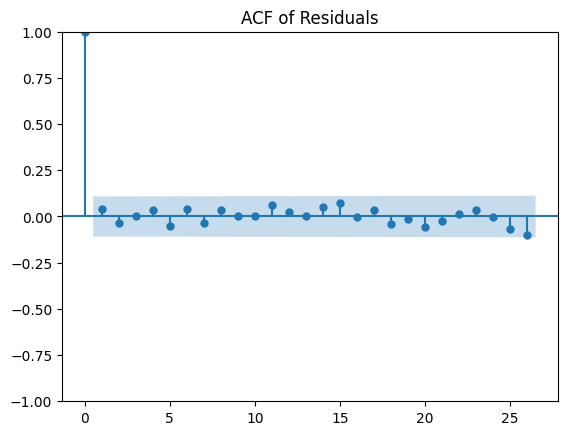

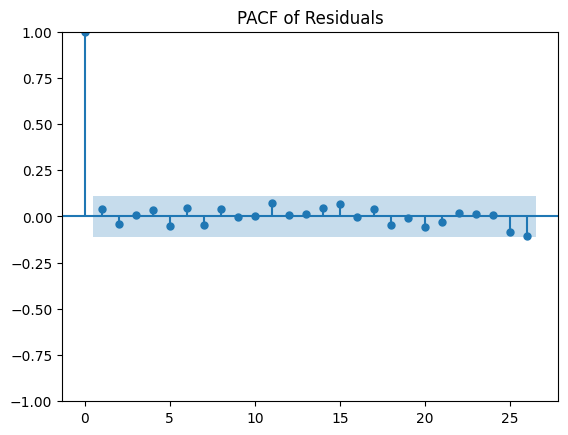

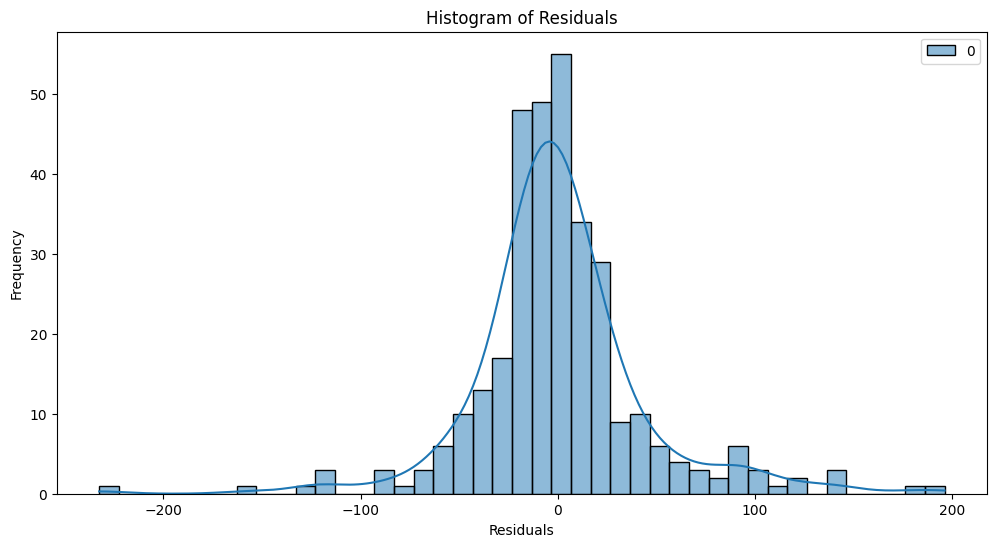

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8274501366483977
P-value: 1.539440028541625e-10
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

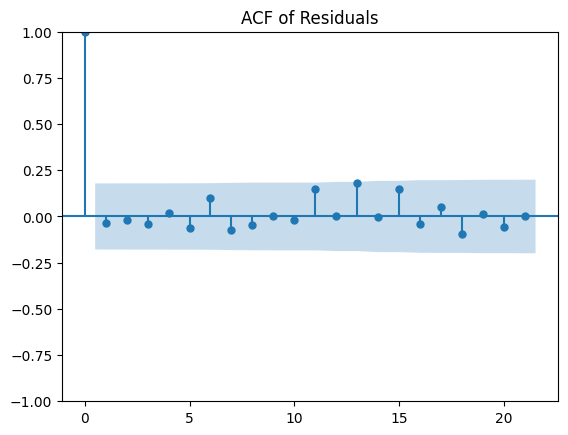

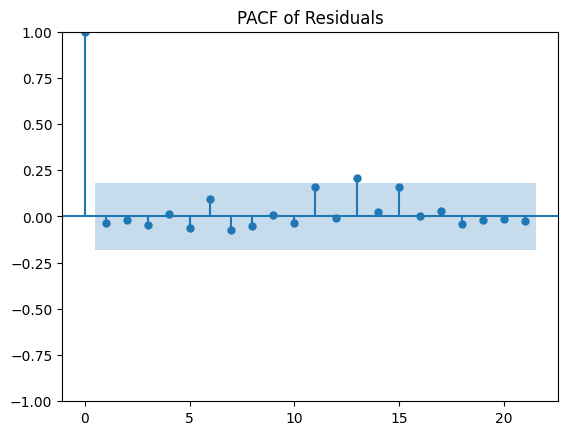

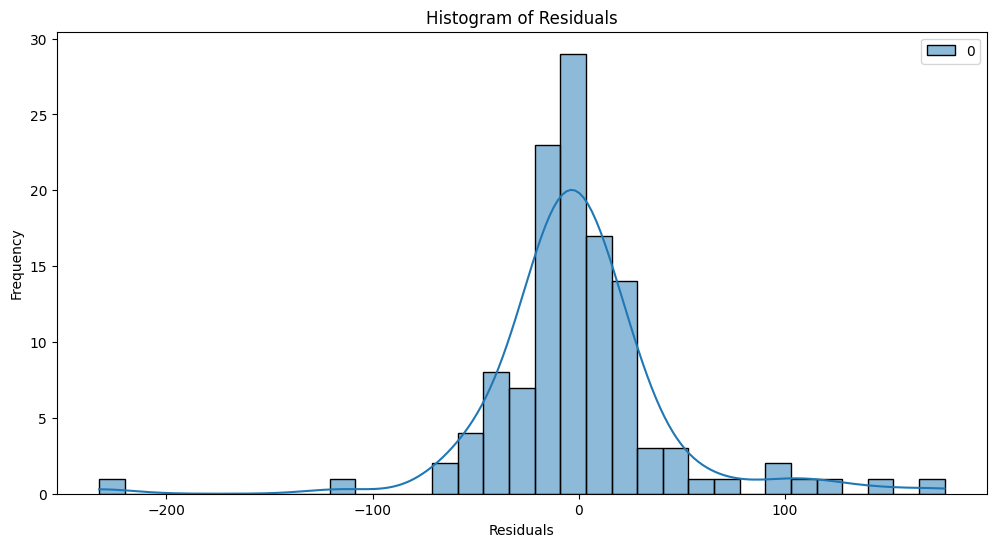

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.913653930298263
P-value: 1.0368399563392624e-12
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

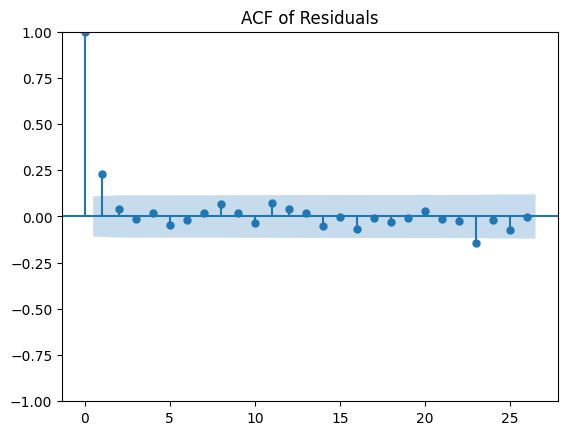

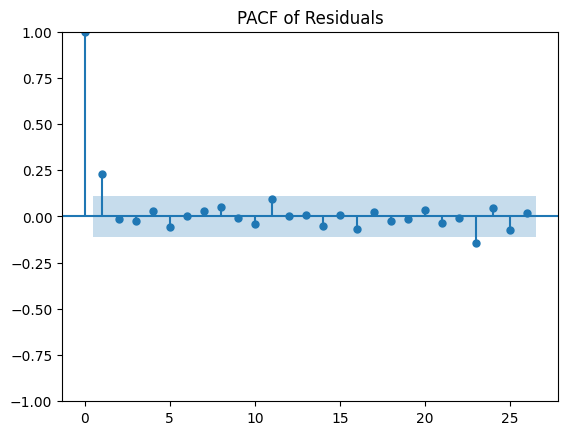

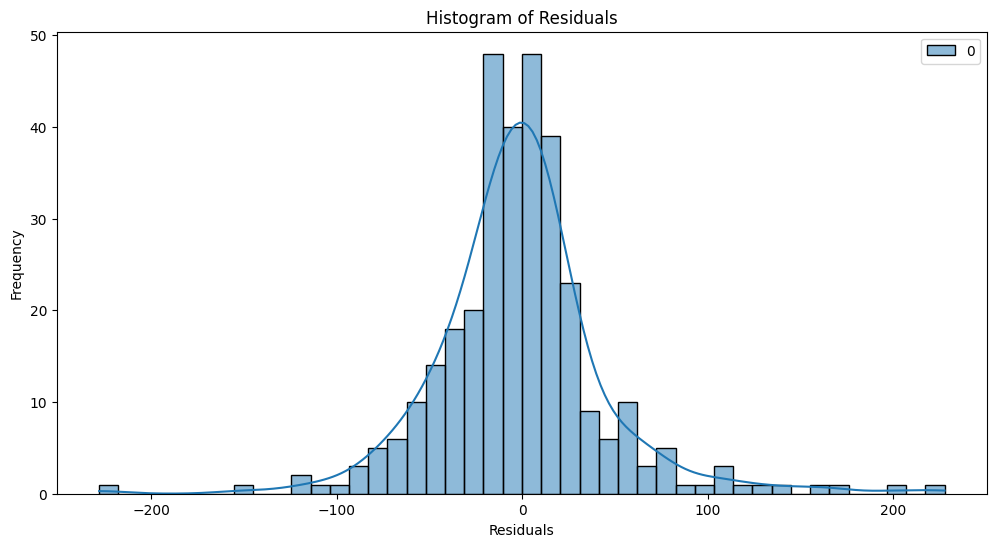

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9102087121893104
P-value: 6.78144557569242e-07
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

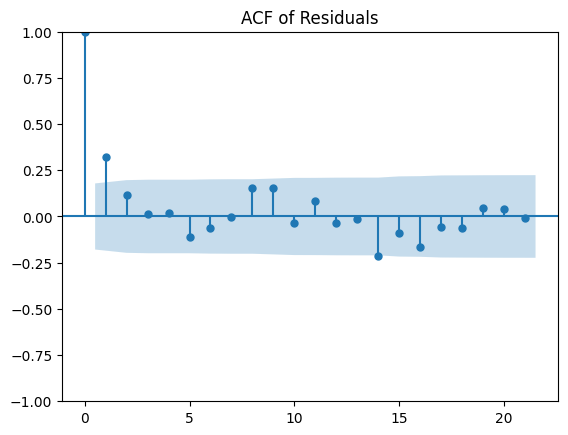

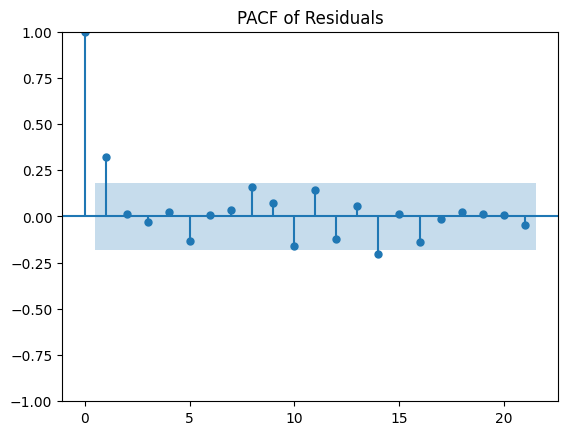

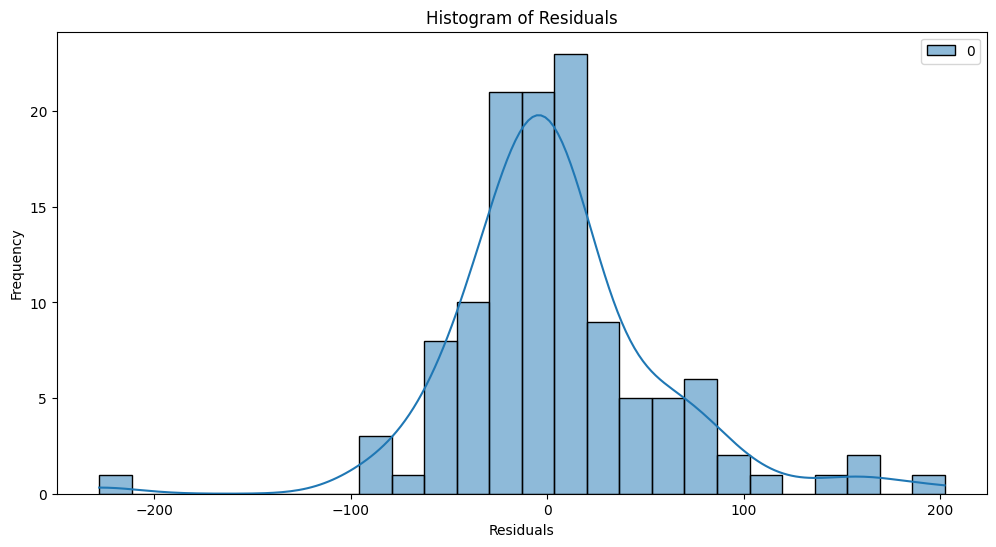

In [49]:
residual_analysis(residuals_final2)